## Orbital Transfer via Trajectory Optimization

In this problem we'll solve for trajectories that will efficiently transfer us from the orbit of one planet to another.

We'll make a few simplifying assumptions about our model of physics for the world we're in:  (1) no relativistic effects, (2) the planets are point masses but are drawn with a massless atmosphere of gas so collisions don't matter, (3) the galaxy is 2D, and (4) the planets themselves do not move, and (5) this is a galaxy for ants, so we'll use "meters" to describe units of length.

### Dynamics

First let's get familiar with what the dynamaics of our system look like.

We are onboard a rocket which is nearby two planets.  If we apply no control, then the dynamics of our system play out like below:

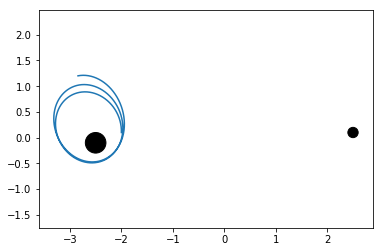

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np

# create a time array
dt = 0.001
num_time_steps = 5000
time_array = np.arange(0.0, dt*num_time_steps, dt)

# initial state
state_initial = np.asarray([-2.0, 0.1, 0.1, 3.])

from orbital_transfer import OrbitalTransferRocket

rocket = OrbitalTransferRocket()
trajectory = rocket.simulate_states_over_time_passive(state_initial, time_array)

%matplotlib inline
rocket.plot_trajectory(trajectory)

### Getting familiar with rocket dynamics

At this time we recommend you start look in `orbital_transfer.py` to understand how the provided components of the `OrbitalTransferRocket` class work.  In case you're wondering, for example if you implement your own system as part of the class project, the dynamics for this one were adapted from the simple orbital mechanics writeup [here](https://astronomy.stackexchange.com/questions/7806/exercise-2d-orbital-mechanics-simulation-python/7814#7814), and just modified to have two non-movable planets, a third body as the rocket, and rocket boosters on the rocket.

### Rocket Booster Control

Rather than hopelessly spin about space though, we have rocket boosters and are not afraid to use them.

In particular let's assume we have two boosters onboard that are facing orthogonal to each other. Since we are in 2D, this is all we need in order to be able to choose our acceleration at any one point in time. Note that we are not concerned about the rotation of the rocket itself.  You may recall that this system is classically known as a *double integrator*, so effectively our system here is a double integrator in a gravitational field.

We can now choose a trajectory over time of control inputs, and change our fate of where we end up in the galaxy.

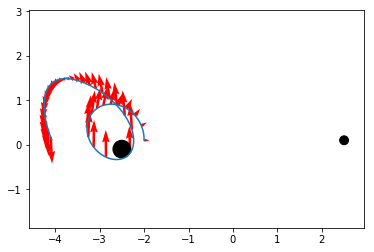

In [2]:
# Choose a sinusoidal oscillation of control inputs over time and see what happens
input_trajectory_x = np.cos(time_array)*.1
input_trajectory_y = np.sin(time_array)*.5
input_trajectory = np.vstack((input_trajectory_x, input_trajectory_y)).T
input_trajectory = input_trajectory[:-1]
# Note that the shape of the input_trajectory is documented in orbital_transfer.py

trajectory = rocket.simulate_states_over_time(state_initial, time_array, input_trajectory)
rocket.plot_trajectory_with_boosters(trajectory, input_trajectory)

Note that here we are using the term "input trajectory", which refers to the sequence of control inputs over time.  In robot world we'll also sometimes call this the "u tape", since it's a tape over time of u's, where $u$ is the control input. An input trajectory is simply:

$$ u_{0}, u_1, ..., u_{N-1}$$

for some sequence of statse:

$$ x_{0}, x_1, ..., x_{N-1}, x_{N}$$

Given some initial state $x_0$ and an input trajectory over time, that is sufficient to simulate, together with the dynamics, how the system will involve.  You can find more documentation about the args/return values of various functions used here inside `orbital_transfer.py`.

### Implementing the Trajectory Optimization

Your mission is to compute input trajectories that will take our rocket from orbiting the planet on the left, over to orbiting the planet on the right.

To succeed on this task, you are welcome to use any method you like, although we will certainly suggest a set of tools for you to use.

In particular your mission is to implement a function with this signature inside `OrbitalTransferRocket`:

```python

 def compute_trajectory_to_other_world(self, state_initial, minimum_time, maximum_time):
    '''
    See orbital_transfer.py for more documentation
    '''
    
    # Please note: three return args
    return trajectory, input_trajectory, time_array

```



There are a handful of components to what constitute successful trajectories.  Successful trajectories must:

#### 1) Efficiently conserve fuel. 

At each time step, this rocket consumes fuel according to 

$$\text{|fuel_used|}^2 = k * |\text{total acceleration}|$$ 

for some constant $k$. This means that a running quadratic cost on control input correlates with measuring
fuel consumption (for evenly spaced time intervals).


#### 2) Reach "orbit" of the far right world

The far right world is defined by `self.world_2_position`.  We will use this relaxed definition of orbit:

1. The rocket must have a total final speed lower than: 1 meter per second
2. The rocket must be .5 meters away from world_2_position
    
It turns out the rocket already has a fantastic different controller to then enter a proper orbit by achieving orbital velocity (all velocity is tangent to the orbit, and precisely at the right orbital speed).

By relaxing this final constraint, it makes it easier for our solvers.

#### 3) Approximately obey dynamic constraints

You are allowed to either exactly obey, or approximately obey (can add slack < .001) for each time step of the trajectory.

#### 4) Begin at the state_initial provided

#### 5) Take no more than maximum_time, no less than minimum_time

### Suggested tools for implementing the trajectory optimization

We've provided a reference notebook, `optimization_and_traj_opt_examples.ipynb`, which has some hopefully useful snippets of code for you to learn the following:

1. Writing down optimization problems, using pydrake's `MathematicalProgram`
2. Using `MathematicalProgram` to implement simple examples of trajectory optimization.

Note that the trajectory optimization examples provided in that example notebook uses an unconstrained shooting method.  For this problem we highly suggest you use the Direct Transcription method which you can find described in the *Underactuated* textbook. 
  
It's also worth noting how different tools can fit together:

- We have implemented `OrbitalTransferRocket` as a Python class which basically only has `numpy` as a dependency, plus some simple `matplotlib` plotting tools.
- `MathematicalProgram`, however, can be used from pydrake to implement optimizations we're interested in, in particular to design trajectories for the `OrbitalTransferRocket` which itself doesn't depend on pydrake.

This is another option for how to put tools together.  A different example is provided by the single legged hopper part of this problem set, which is a implemented as a Drake system (inherits from `VectorSystem`) and uses Drake to do the simulation by brining in the robot model from an `.sdf` description.

  
** Optional note to read in case you're interested:  The reason that Direct Transcription will work much better for this problem is that we will be using symbolic gradients, which will quickly become very complicated for long, unconstrained, and dynamically complicated trajectories that would come out of a shooting method.  Shooting might work OK with "autodiff" gradients, but Direct Transcription should work well with symbolic gradients for a problem of this size(and autodiff too), and it's a good learning opportunity to do this way.

### Hints

- You'll need to use a much coarser discretization of time than in the simulations provided above, in order to keep the number of decision variables reasonably low.  We call each of the time discretizations of the trajectory optimization a "knot point". We recommend ~50-100 knot points for this problem.
- You may need to add constraints so that the dynamics don't get too crazy during the search.  Think about a coule of simple guidelines that you want to give the optimization.  Do you want to ever want to go infininetly far away from the planets?  Do you want to be too close?

### Final notes for this problem

- You do not need to change anything about this notebook, the only functions that will be used for testing are those from `orbital_transfer.py`
- Feel free to add any helper functions, plotting tools, etc that you'd like to add
- Trajectory optimization is both very powerful but also can have unexpected effects.  Please ask on Piazza, work with others in the class, and/or come to office hours if you have questions.
- Note that Drake has excellent implementations of trajectory optimization already, which you may find useful for reference.  At this time of writing, Drake's own trajectory optimization can be called from pydrake, but only for systems which have been implemented in C++ (see the acrobot, cartpole, pendulum examples in the textbook).  By this time next week or two, though, it will be possible to call pydrake's own trajectory optimization from Python-implemented classes.
- We think you'll gain a lot by completing the challenge of implementing your own trajectory optimization.  While a successful solution won't be that many lines of code, it may require some careful consideration.
- Good luck and happy orbit transfering!

In [5]:
# Invokes your trajectory optimization
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from orbital_transfer import OrbitalTransferRocket
rocket = OrbitalTransferRocket()

x0 = np.array([-2., 0.1, -0.1, 3])#[-2.0,   0.5, -0.4,  0.0 ])#[-2., 0.1, -0.1, 3])
minimum_time = 5.
maximum_time = 15.
traj, u_traj, time_array = rocket.compute_trajectory_to_other_world(x0, minimum_time, maximum_time)
rocket.plot_trajectory_with_boosters(traj, u_traj)

13.0
[-2.   0.1 -0.1  3. ]


RuntimeError: Formula (state_1(1) == (state_0(1) + 0.26000000000000001 * state_0(3) + cos((u_0(0) / 100)))) is non-linear.

## Run tests

In [3]:
import os
# Run the tests
os.popen("python test_set_4.py ./test_results.json")

# Print the results json for review
import test_set_4
print test_set_4.pretty_format_json_results("test_results.json")

Test Run a few trajectory optimizations once, and persist the output: 1.00/1.00.
  * 13.0 [-2.   0.4 -0.1  3. ] True 13.0 [-2.8  0.2  0.1  1. ] True 13.0
  * [-2.   0.5 -0.4  0. ] True 13.0 [-3.2  0.2  0.1  1. ] True

Test Check that the system approximately obeys the original dynamics: 4.00/4.00.

Test Check that the trajectory was reasonably efficient with fuel use: 4.00/4.00.
  * 6.10727957176 31.1036167664 12.873519376 12.651566297

Test Check that the initial state is valid: 10.00/10.00.

Test Check that the original parameters have not been changed: 1.00/1.00.

Test Check that the trajectory satisfied the specified 'orbit' constraint: 10.00/10.00.
  * 0.25 0.250000000087 0.250000000704 0.250000000005

Test Check that the time_array is valid: 4.00/4.00.

Test Verify that the hopper keeps hopping for 10s: 10.00/10.00.
  *  /notebooks/hopper_2d.py:261: DrakeDeprecationWarning:
  * '_DoHasDirectFeedthrough' is deprecated and will be removed on or
  * around 2019-06-15. Please call 'D